<a href="https://colab.research.google.com/github/HenriqueCCdA/BC_DS_Projeto_Final/blob/main/Notebooks/ML/treinamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1) Resumo

Neste notebook foram feitos os treinamentos e seleção de hyperparamentros de 6 modelos de **ML** distintos. Os modelos estudados foram:

* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* Forest Tree
* Support Vector Machine
* KNeighbors

A busca pelos hyperparametros foram feitas pelo GridSearchCV ou pelo RandomizedSearchCV. Para a Cross Validation foi usado **RepeatedStratifiedKFold** com **5** divições de **10** repetições.

O parametro utilizado para avaliação do modelo foi **ROC_AUC** e quantidade de **falsos negativos** (FN).

A base de dados utilizados tem **351** amostras com **52** variaveis explicativas. Dessas **351** amostras **298** foram usados para **Cross Validation** (treino + teste) e **53** foram usados para a **validação**.


---
# 2) Pre-analise

---
## 2.1) Minhas Funções

In [18]:
# Maquina Local 
if(True):
    import sys
    sys.path.insert(1, "../../")

    from src.plota_graficos import plota_curva_roc, plota_matriz_de_confusao
    from src.ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv, treina,\
                        treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos 

    from src.info import proporcao_y, numero_teste_treino_val, resultados_treinamento, dimensao_dados, variaveis_explicativas

# Collab
else:
   !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/requirements.txt"
   !pip3 install -r requirements.txt
   !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/plota_graficos.py"
   !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/ml.py"
   !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/info.py"

   from plota_graficos import plota_curva_roc, plota_matriz_de_confusao
   from ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv, treina, \
                  treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos

   from info import proporcao_y, numero_teste_treino_val, resultados_treinamento, dimensao_dados, variaveis_explicativas

---
## 2.2) Importando libs

In [19]:
import pandas as pd
#
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#
import matplotlib.pyplot as plt
#
import numpy as np
#
from scipy.stats import uniform

## 2.3) Versão dos bibilotecas

In [20]:
import sklearn as sk
import scipy   as sc
import matplotlib as mpl

print(f'scipy      : {sc.__version__}')
print(f'sklearn    : {sk.__version__}')
print(f'pandas     : {pd.__version__}')
print(f'numpy      : {np.__version__}')
print(f'matplotlib : {mpl.__version__}')

scipy      : 1.6.2
sklearn    : 0.24.2
pandas     : 1.2.4
numpy      : 1.20.2
matplotlib : 3.3.4


---
# 3) Lendo os dados

In [21]:
path = "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/Dados/Tratados/dados_sem_coor_acima_do_valor_de_corte.csv"

dados_com_corte = pd.read_csv(path)

dimensao_dados(dados_com_corte)

dados_com_corte.tail(n=5)

Numero de linhas : 351 
Numero de colunas: 53 


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
346,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.860241,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.418803,1
347,1,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.855422,-0.978029,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.589744,0
348,0,-0.111111,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.787952,-0.964461,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,-0.299145,1
349,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.937349,-0.978029,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,-0.247863,0
350,0,-0.111111,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.879518,-0.979571,0.012346,-0.292308,0.056604,-0.525424,0.535714,0.789474,-0.299145,0


In [22]:
dados_com_corte.describe()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.458689,-0.046534,0.381766,0.108262,0.022792,0.091168,0.019943,0.128205,0.045584,0.196581,...,-0.841746,-0.960159,-0.045990,-0.318411,-0.240403,-0.468207,0.097772,0.760029,-0.313074,0.461538
std,0.499002,0.640366,0.486513,0.311155,0.149453,0.288259,0.140004,0.334795,0.208879,0.397980,...,0.135197,0.098682,0.253692,0.274796,0.278347,0.213326,0.272230,0.116880,0.185592,0.499230
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.971084,-1.000000,-0.654321,-0.938462,-0.823899,-0.954802,-0.571429,0.263158,-0.760684,0.000000
25%,0.000000,-0.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.898795,-0.983811,-0.185185,-0.538462,-0.415094,-0.593220,-0.107143,0.684211,-0.418803,0.000000
50%,0.000000,-0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.874699,-0.978029,-0.037037,-0.369231,-0.283019,-0.525424,0.071429,0.789474,-0.299145,0.000000
75%,1.000000,0.555556,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.821687,-0.971784,0.086420,-0.153846,-0.094340,-0.389831,0.250000,0.842105,-0.213675,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.513241,0.604938,0.553846,1.000000,0.830508,0.964286,1.000000,0.487179,1.000000


In [23]:
_ = variaveis_explicativas(dados_com_corte)

 col[  0] -> AGE_ABOVE65                    col[  1] -> AGE_PERCENTIL                  
 col[  2] -> GENDER                         col[  3] -> DISEASE GROUPING 1             
 col[  4] -> DISEASE GROUPING 2             col[  5] -> DISEASE GROUPING 3             
 col[  6] -> DISEASE GROUPING 4             col[  7] -> DISEASE GROUPING 5             
 col[  8] -> DISEASE GROUPING 6             col[  9] -> HTN                            
 col[ 10] -> IMMUNOCOMPROMISED              col[ 11] -> OTHER                          
 col[ 12] -> ALBUMIN_MEDIAN                 col[ 13] -> BE_ARTERIAL_MEDIAN             
 col[ 14] -> BE_VENOUS_MEDIAN               col[ 15] -> BIC_VENOUS_MEDIAN              
 col[ 16] -> BILLIRUBIN_MEDIAN              col[ 17] -> BLAST_MEDIAN                   
 col[ 18] -> CALCIUM_MEDIAN                 col[ 19] -> CREATININ_MEDIAN               
 col[ 20] -> FFA_MEDIAN                     col[ 21] -> GGT_MEDIAN                     
 col[ 22] -> GLUCOSE_MEDIAN     

### Divindido os dados em validação e Cross Valadiation (teste+treino)

In [24]:
x_cv, x_val, y_cv, y_val = cv_val_split(dados_com_corte, p_val = .15, seed = 14715)

### Verificando se a proporção foi mantida 

In [25]:
proporcao_y(dados_com_corte['ICU'])
proporcao_y(y_val)
proporcao_y(y_cv )

Proporcao do ICU
Campo 0 ->  53.85%
Campo 1 ->  46.15%
Proporcao do ICU
Campo 0 ->  54.72%
Campo 1 ->  45.28%
Proporcao do ICU
Campo 0 ->  53.69%
Campo 1 ->  46.31%


In [26]:
numero_teste_treino_val(dados_com_corte['ICU'], y_val, y_cv)

Número total de entradas                         : 351
Número total de entradas para validacao          : 53
Número total de entradas para o Cross Validation : 298


# 4) Modelo de ML

A opção **refit** foi deixado como **true** logo depois que o melhor modelo for selecioando o RandomizedSearchCV/GridSearchCv **re-treina** esse modelo com o dataset completo (treino+teste). 

In [27]:
n_iter   = 20
n_splits = 5
n_repeats= 10
seed     = 14715

## 4.1) DummyClassifier

> Aqui será treinado do modelo **DummyClassifier**. Para o treino foi usado **GridSearchCV**. O único hyperparametro disponivel foi **strategy**. O intervalor de busca  **[stratified, 'ost_frequent, prior, 'uniform]**. O DummyClassifier será usado como o nosso modelo **"baseline"**



In [28]:
modelo = DummyClassifier(random_state=seed)

parameters = {'strategy' : ['stratified', 'most_frequent', 'prior', 'uniform']}

resultados, melhor_modelo_dummy, melhores_hyperparametros  = treina_modelo_grid_search_cv(modelo,
                                                                                      x_cv,
                                                                                      y_cv,
                                                                                      parameters,
                                                                                      n_splits=n_splits,
                                                                                      n_repeats=n_repeats,
                                                                                      seed=seed)

resultados_treinamento(resultados, melhor_modelo_dummy, melhores_hyperparametros)

Fitting 50 folds for each of 4 candidates, totalling 200 fits
melhores hyperparametros : {'strategy': 'stratified'}
Melhor modelo            : DummyClassifier(random_state=14715, strategy='stratified')


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'strategy': 'stratified'},0.50332,0.501305,0.066405,0.024165,0.001939,0.001138,0.003458,0.001539,1
1,{'strategy': 'most_frequent'},0.50000,0.500000,0.000000,0.000000,0.001959,0.000999,0.002978,0.001516,2
2,{'strategy': 'prior'},0.50000,0.500000,0.000000,0.000000,0.002318,0.001701,0.003758,0.002112,2
3,{'strategy': 'uniform'},0.50000,0.500000,0.000000,0.000000,0.001619,0.000660,0.003058,0.001653,2


---
## 4.2) Regreção logistica

> Aqui será treinado do modelo **LogisticRegression**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* C             : [0, 4]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


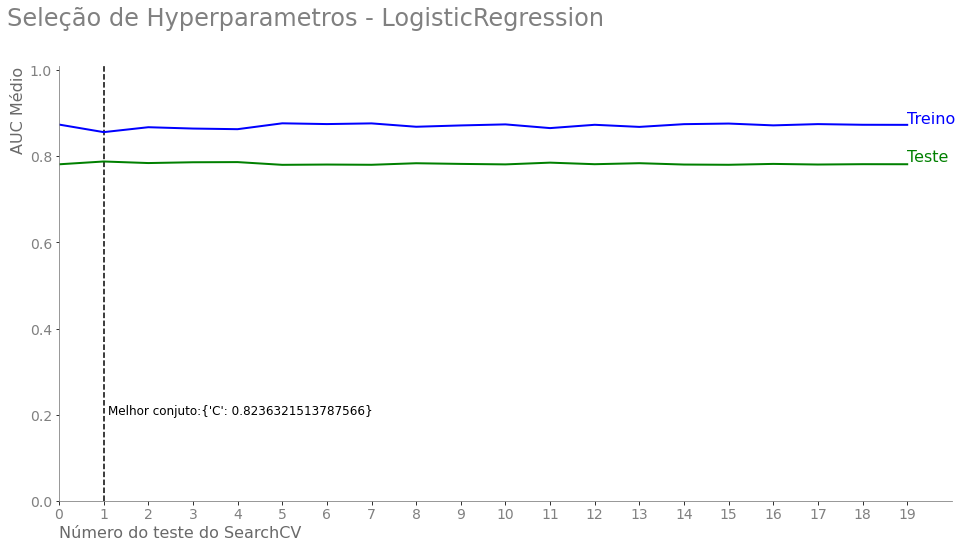

melhores hyperparametros : {'C': 0.8236321513787566}
Melhor modelo            : LogisticRegression(C=0.8236321513787566, max_iter=1000, tol=1e-06)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'C': 2.9403726439047437},0.781518,0.873801,0.047548,0.010148,0.079631,0.029773,0.008275,0.003719,13
1,{'C': 0.8236321513787566},0.788031,0.856227,0.043093,0.009138,0.039606,0.009735,0.006846,0.002453,1
2,{'C': 1.8107081253404766},0.784416,0.867636,0.045879,0.009911,0.052839,0.008337,0.006636,0.002095,5
3,{'C': 1.4507591152545065},0.786261,0.864535,0.045216,0.009699,0.057845,0.043927,0.007837,0.004312,3
4,{'C': 1.3163817298661398},0.786619,0.863075,0.045085,0.009760,0.066495,0.023213,0.009847,0.008546,2
5,{'C': 3.7627108804741063},0.780275,0.876705,0.048803,0.010177,0.096739,0.031852,0.007712,0.003267,20
6,{'C': 3.2348466053974367},0.780952,0.874934,0.047959,0.010246,0.065658,0.009589,0.006820,0.002027,17
7,{'C': 3.6987640689695644},0.780386,0.876524,0.048652,0.010167,0.074423,0.018972,0.006780,0.002452,19
8,{'C': 1.9704679412547428},0.783981,0.868716,0.046126,0.009962,0.063394,0.030577,0.006739,0.002088,7
9,{'C': 2.4854242092996466},0.782442,0.871786,0.047091,0.010074,0.081076,0.042704,0.008467,0.004835,8


In [29]:
parameters = {'C': uniform(loc=0, scale=4)}
modelo = LogisticRegression(max_iter=1000, tol=1e-6)

melhor_modelo_lr, res = treina(modelo = modelo,
                        x = x_cv, 
                        y = y_cv, 
                        parameters = parameters, 
                        n_splits = n_splits, 
                        n_repeats = n_repeats, 
                        n_iter = n_iter, 
                        seed = seed, 
                        titulo = 'Seleção de Hyperparametros - LogisticRegression',
                        n = 20)

res

---
## 4.3) Arvore de decissão

> Aqui será treinado do modelo **DecisionTreeClassifier**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* max_depth       : [1-20]
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


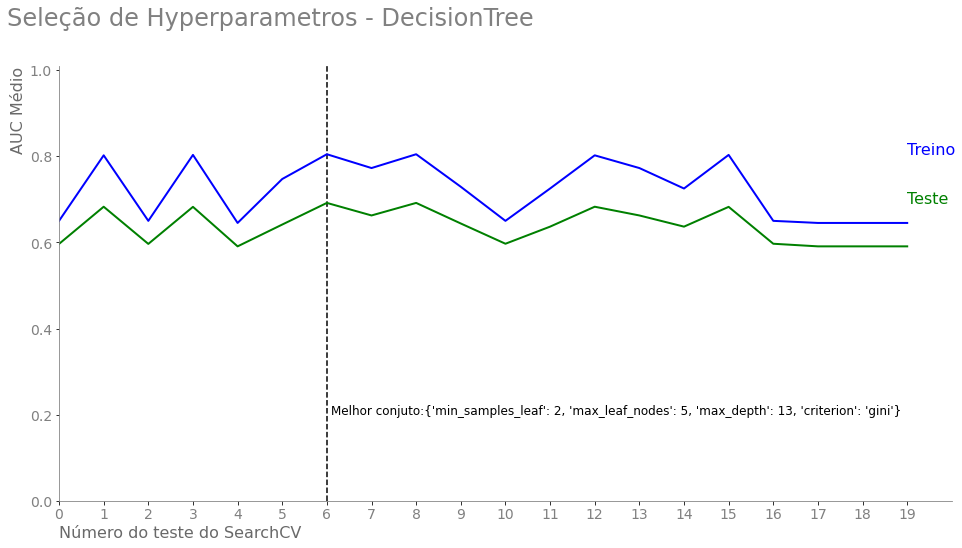

melhores hyperparametros : {'min_samples_leaf': 2, 'max_leaf_nodes': 5, 'max_depth': 13, 'criterion': 'gini'}
Melhor modelo            : DecisionTreeClassifier(max_depth=13, max_leaf_nodes=5, min_samples_leaf=2)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.596639,0.650174,0.052088,0.021485,0.010023,0.007528,0.006856,0.002666,15
1,"{'min_samples_leaf': 1, 'max_leaf_nodes': 5, '...",0.682982,0.802352,0.056409,0.019538,0.010442,0.002521,0.007136,0.002390,3
2,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.596639,0.650174,0.052088,0.021485,0.007870,0.002895,0.007436,0.003323,15
3,"{'min_samples_leaf': 4, 'max_leaf_nodes': 5, '...",0.682689,0.803327,0.057765,0.019709,0.011101,0.004358,0.007236,0.006146,5
4,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.590933,0.645317,0.051073,0.023998,0.010733,0.005720,0.008235,0.003488,17
5,"{'min_samples_leaf': 4, 'max_leaf_nodes': 5, '...",0.641579,0.747360,0.047114,0.022287,0.009014,0.004148,0.008015,0.004467,10
6,"{'min_samples_leaf': 2, 'max_leaf_nodes': 5, '...",0.691842,0.804882,0.058337,0.015339,0.012592,0.005731,0.011514,0.008203,1
7,"{'min_samples_leaf': 3, 'max_leaf_nodes': 4, '...",0.662715,0.772810,0.052479,0.023372,0.011643,0.003211,0.007755,0.002477,7
8,"{'min_samples_leaf': 3, 'max_leaf_nodes': 5, '...",0.691842,0.804882,0.058337,0.015339,0.008754,0.002204,0.006796,0.002497,1
9,"{'min_samples_leaf': 3, 'max_leaf_nodes': 3, '...",0.644032,0.729311,0.048791,0.017485,0.008015,0.002111,0.006551,0.001896,9


In [30]:
parameters = {'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = DecisionTreeClassifier()

melhor_modelo_arvore, res = treina(modelo = modelo,
                            x = x_cv, 
                            y = y_cv, 
                            parameters = parameters, 
                            n_splits = n_splits, 
                            n_repeats = n_repeats, 
                            n_iter = n_iter, 
                            seed = seed, 
                            titulo = 'Seleção de Hyperparametros - DecisionTree',
                            n = 20)

res

---
## 4.4) Forest Tree

> Aqui será treinado do modelo **Forest Tree**. No treino foi usado **RandomizedSearchCV** com **10** iterações. Os hyperparametros foram:
>* n_estimators    : [10, 50, 100, 150, 200]
>* max_depth       : [1, 20]    
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


In [ ]:
parameters = {'n_estimators'    : [10, 50, 100, 150, 200],
              'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = RandomForestClassifier(random_state=0)

melhor_modelo_forest, res = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - RandomForest',
                              n = 20)

res

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


> 

## 4.5) Support Vector Classification.

> Aqui será treinado do modelo **SVC**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* kernel        : [linear, poly, rbf, sigmoid]
>* C             : [0, 2]
>* gamma         : [scale, auto]
>* shrinking     : [True , False]

In [ ]:
parameters = {'kernel'          : ['linear', 'poly', 'rbf', 'sigmoid'],
              'C'               : uniform(loc=0, scale=2),
              'gamma'           : ['scale', 'auto'],
              'shrinking'       : [True, False]
             }

modelo = SVC(probability=True)

melhor_modelo_svc, res = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - SVC',
                              n = 20)

res

## 4.5) KNeighbors

> Aqui será treinado do modelo **KNeighbor**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* n_neighbors   : [1, 10]
>* p             : [1, 2]
>* weights       : [uniform, distance]
>* algorithm     : [auto, ball_tree, kd_tree, brute]

In [ ]:
parameters = {'n_neighbors'     : np.arange(1, 11),
              'p'               : [1, 2],
              'weights'         : ['uniform', 'distance'],
              'algorithm'       : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

modelo = KNeighborsClassifier()

melhor_modelo_kn, res = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - KNeighborsClassifier',
                              n = 20)

res


# 5) Avaliando o melhor modelo

> Agora vamos avaliar o melhor modelo encontrado utilizando o dados de validação.

In [ ]:
modelos = [melhor_modelo_dummy, 
           melhor_modelo_lr, 
           melhor_modelo_arvore, 
           melhor_modelo_forest, 
           melhor_modelo_svc,
           melhor_modelo_kn] 

In [ ]:
desempenho_dos_modelos(modelos, x_val, y_val)

In [ ]:
plota_matriz_de_confusao(modelos, x_val, y_val)

In [ ]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Validação', x=x_val, y=y_val)

In [ ]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Treino-Teste', x=x_cv, y=y_cv)